In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [76]:
df = pd.read_csv('D:\Documents\Work\PSPH\Volumes\Data\\weekly volumes.csv')
df.head()

,Admit Week Date,End of Week Display Date,All Ministries,Alaska,NorCal,Oregon,Puget Sound,SoCal,Texas/NM,WA/MT
0,12/31/2017,1/6/2018,116661,4171,10160,29348,22181,28940,4664,17197
1,1/7/2018,1/13/2018,131198,4351,11206,35497,24924,30474,5069,19677
2,1/14/2018,1/20/2018,131382,4467,10085,37578,24304,30397,4876,19675
3,1/21/2018,1/27/2018,130872,4347,10449,36740,24295,29118,5112,20811
4,1/28/2018,2/3/2018,133769,4615,12048,34609,24187,32468,5718,20124


Text(0.5, 1.0, 'Patient Volumes')

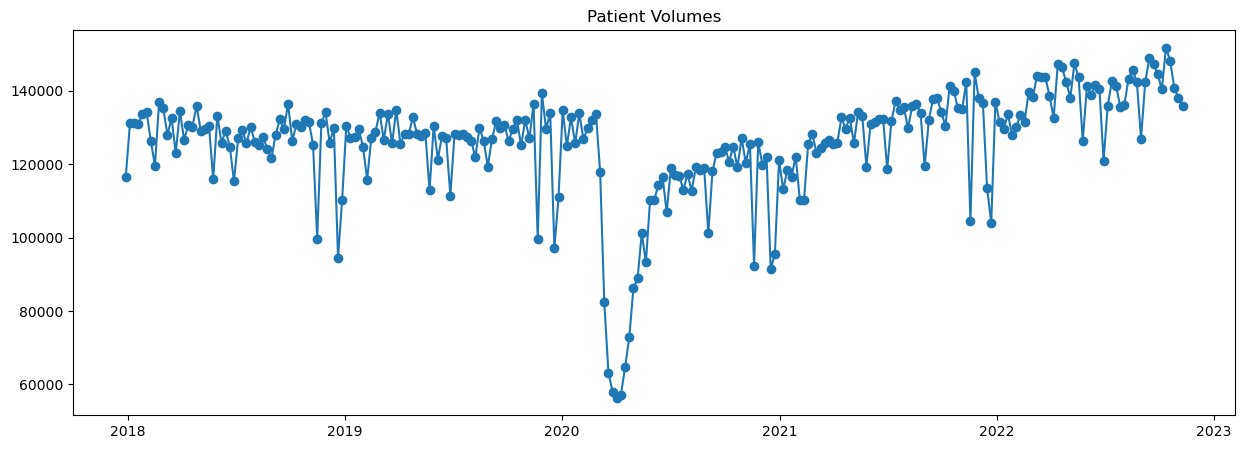

In [60]:
t = np.arange("2017-12-31", "2022-11-19", dtype = "datetime64[W]")
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t, df['All Ministries'])
ax.scatter(t, df['All Ministries'])
ax.set_title('Patient Volumes')

Text(0.5, 1.0, 'Patient Volumes: \n Southwest')

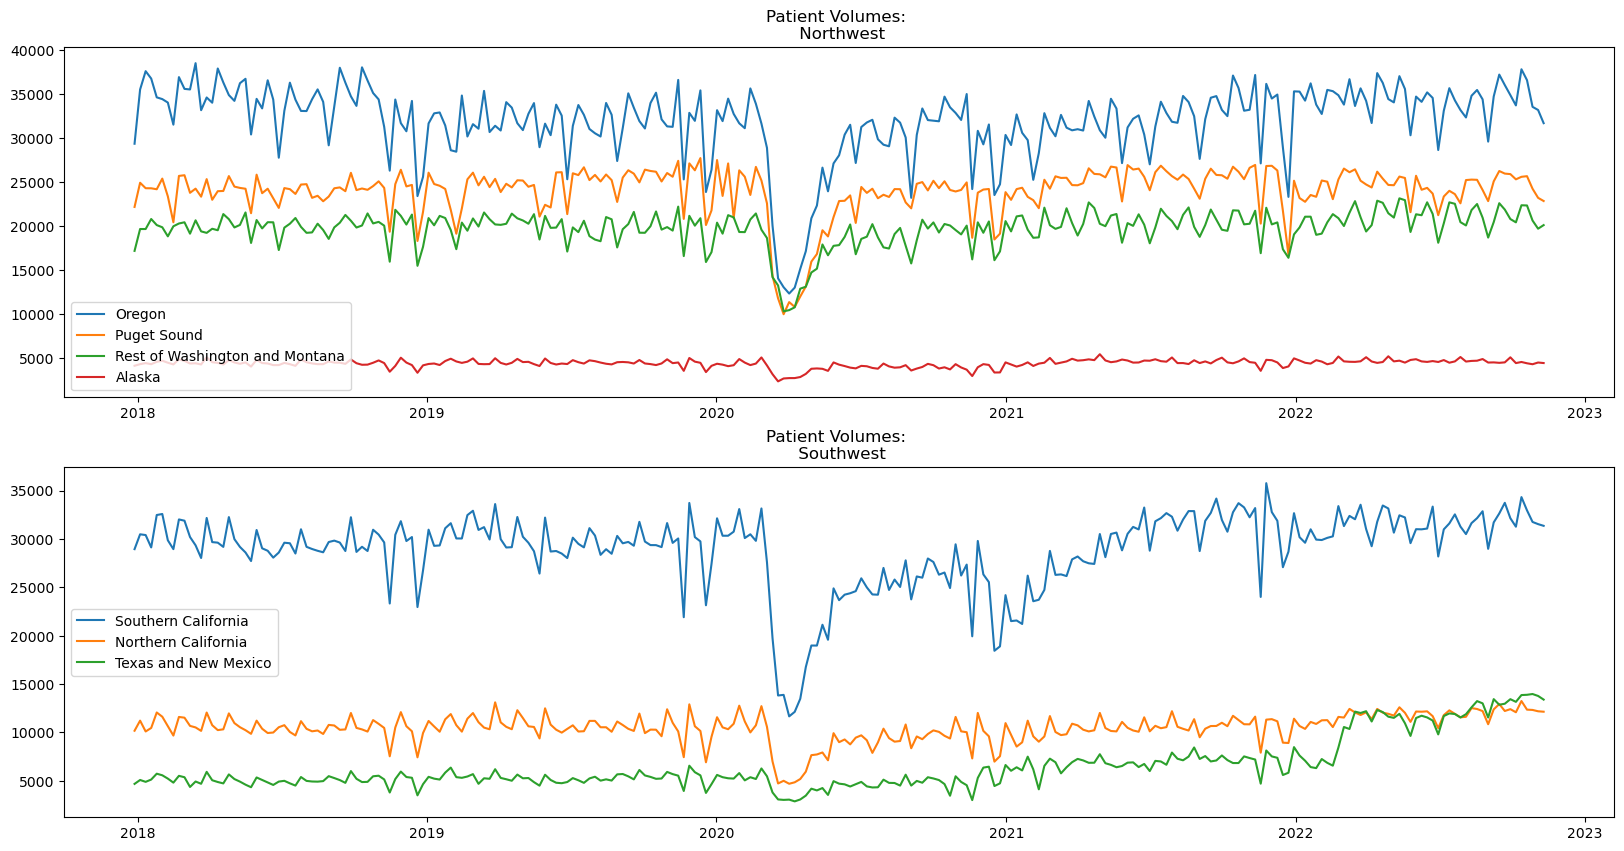

In [82]:
fig, axs = plt.subplots(2,1, figsize = (20,10))
axs[0].plot(t, df['Oregon'], label = 'Oregon')
axs[0].plot(t, df['Puget Sound'], label = 'Puget Sound')
axs[0].plot(t, df['WA/MT'], label = 'Rest of Washington and Montana')
axs[0].plot(t, df['Alaska'], label = 'Alaska')
axs[0].legend(loc = 'lower left')
axs[0].set_title('Patient Volumes: \n Northwest')

axs[1].plot(t, df['SoCal'], label = 'Southern California')
axs[1].plot(t, df['NorCal'], label = 'Northern California')
axs[1].plot(t, df['Texas/NM'], label = 'Texas and New Mexico')
axs[1].legend(loc = 'center left')
axs[1].set_title('Patient Volumes: \n Southwest')